# Распознавание лиц

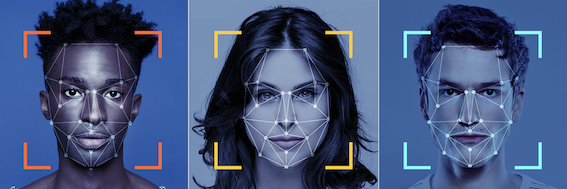

В этом проекте мы будем решать задачу распознавания лиц. Мы обучим нейросеть и поиграем с различными функциями потерь и метриками. Обучение будем производить на наборе данных [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Посмотрим на пример данных:

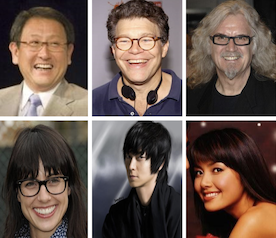

Мы видим фотографии людей. Лица видны, но они располагаются в разных частях фотографий. Для успешного решения нашей задачи такие данные необходимо обработать.

Начнём с того, что опишем общий подход к распознаванию лиц.

## Описание общего подхода к решению задачи

Перед обучением нейросетевой модели фотографии лиц необходимо выровнять. Этот шаг очень важен для достижения выского качества при распознавании.

Выравнивание состоит из трёх этапов:
1. Для каждой фотографии определяются координаты элементов лица (глаз, носа, уголков рта). Для этого обычно используются специально обученные нейросети;
2. Каждая фотография вращается таким образом, чтобы координаты глаз располагались на заренее заданной горизонтальной линии;
3. Каждая фотография масштабируется, чтобы размеры всех лиц были примерно схожими.

Посмотрим на пример обработанных фотографий:

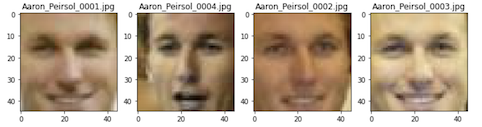

Здесь глаза расположены на одном уровне, а общие размеры лиц примерно совпадают. Такие данные намного лучше подходят для обучения нейросети, так как часть работы по выделению лица и выравниванию характерных признаков уже будет проделана.

Предположим что мы успешно обучили модель распознавания лиц и хотим применять её для распознавания лиц работкников в офисе. Для этого нам также придётся прочти несколько этапов:
1. обнаружение лица
2. выравнивание лица
3. распознавание лица

Пройдёмся по всему процессу.

Пусть на стене офиса висит камера, с которой мы получаем какое-то изображение.

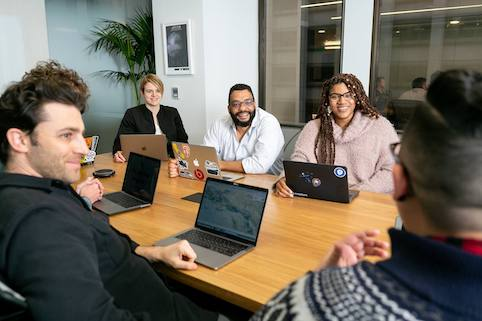

Прежде чем распознавать лица нам нужно их обнаружить. Для этого нам понадобиться специально обученная под эту задачу нейросеть.

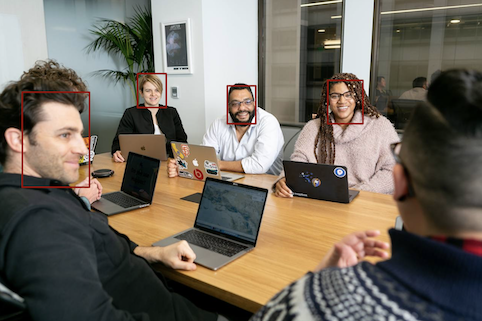

Обнаруженные лица необходимо выровнять. Процедура вырванивания должна совпадать с процедурой, использованной при обработке обучающих данных. В результате мы получим примерно такие изображения:

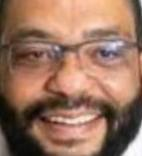

Наконец, обработанные данные передаются нейросети, обученной для задачи распознавания лиц. Более подробно весь процесс описан, например, [в этой статье](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/).

Обучение нейросетей для обнаружения и выравнивания лиц не входит в задачи данного проекта, мы сосредоточимся непосредственно на задаче распознавания.

## Описание архитектуры нейросети для распознавания лиц

Фактически перед нам стоит задача классификации. Пусть у нас есть набор из фотографий `N` людей. Мы можем обучить нейросеть распределять фотографии по `N` классам, каждый класс будет соответствовать одному человеку.

Однако перед нами встаёт вопрос: а как применять такую нейросеть, если нам понадобится распознать лицо нового человека? Всё просто, после обучения модели мы отбросим последний (классифицирующий) слой. На выходе мы получим результаты работы предпоследнего слоя — эмбединг лица. Мы можем сравнивать эмбединги различных изображений с помощью косинусного расстояния. Чем меньше расстояние, тем больше вероятность, что перед нами фотографии одного и того же лица.

Таким образом мы сможем работать с любыми фотографиями лиц, сравнивать их между собой и выявлять фотографии, на которых изображён один человек.

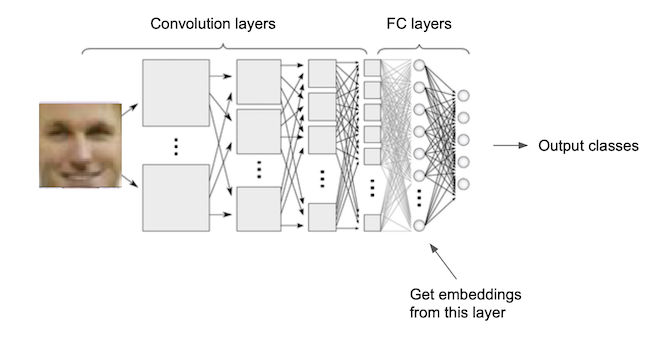

## Обучение нейросетевой модели

Загрузим нужные библиотеки.

In [1]:
import os
from itertools import combinations
from itertools import product
from collections import defaultdict

import cv2

import pandas as pd
import numpy as np
from numpy.linalg import norm

from PIL import Image
from PIL import ImageFile

from skimage import io
from skimage import transform

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

import torchvision.transforms as transforms

from torchmetrics import Accuracy

import lightning as L

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import plotly.express as px
import matplotlib.pyplot as plt

import faiss

from pytorch_metric_learning import losses as lsss

from sklearn.manifold import TSNE

In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
L.seed_everything(42)

Global seed set to 42


42

### Подготовка данных

Для обучения нашей нейронной сети воспользуемся фотографиями из набора [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), которые уже были обработаны и выровнены.

Наши данные имеют следующую стркутуру:
* папка `celebA_imgs` содержит выровненные фотографии;
* файл `celecA_anno.txt` содержит аннотации (информацию об изображённых людях) ко всем фотографиям;
* файл `celecA_train_split.txt` позволяет удобно разделить фотографии на обучающую, валидационную и тестовую выборки.

Посмотрим на некоторые фотографии, чтобы оценить, с какими данными нам придётся работать.

In [4]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs), 5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i])
        axes[i].set_title(images_names[i])
    plt.show()

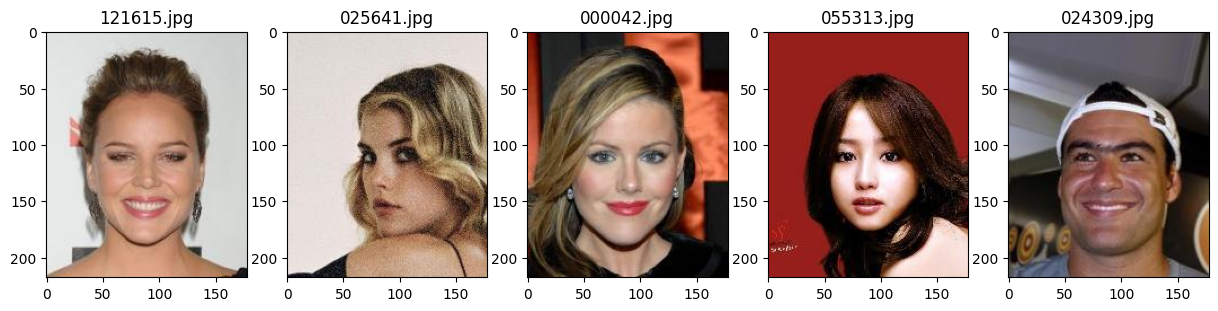

In [5]:
images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)

Хорошо. Лица расположены примерно в центре фото, линия глаз везде находится приблизительно на одном уровне. Теперь нам нужно сформировать обучающий, валидационный и тестовый наборы данных. Начнём с подготовки класса `Dataset`.

In [6]:
def get_paths(dataset_type='train'):
    '''
    a function that returns the list of images paths for a given type of the dataset
    params:
      dataset_type: 'train', 'val' or 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2
    }
    with open('celebA_train_500/celebA_train_split.txt', 'r') as f:
        lines = f.readlines()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = [os.path.join('celebA_train_500/celebA_imgs/', filename) for filename in lines]
    
    return np.array(images_paths)

In [7]:
class CelebsDataset(Dataset):
    def __init__(self, dataset_type):
        self.images = get_paths(dataset_type=dataset_type)
        with open('celebA_train_500/celebA_anno.txt', 'r') as f:
            labels = f.readlines()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        if dataset_type == 'train':
            self.transform = transforms.Compose([
                transforms.Resize(160),
                transforms.CenterCrop(160),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomGrayscale(),
                transforms.GaussianBlur(kernel_size=5),
                transforms.RandomRotation(degrees=10),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(160),
                transforms.CenterCrop(160),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]

        return image, label

In [8]:
class CelebsDataModule(L.LightningDataModule):
    def __init__(self, batch_size: int = 256) -> None:
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str) -> None:
        self.train_set = CelebsDataset(dataset_type='train')
        self.val_set = CelebsDataset(dataset_type='val')
        self.test_set = CelebsDataset(dataset_type='test')

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_set, batch_size=self.batch_size, 
                          shuffle=True, num_workers=8, pin_memory=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_set, batch_size=self.batch_size, 
                          shuffle=False, num_workers=8, pin_memory=True)
    
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_set, batch_size=self.batch_size, 
                          shuffle=False, num_workers=8, pin_memory=True)

In [9]:
data_module = CelebsDataModule(batch_size=64)

### Обучение модели

Нам нужно подготовить и обучить модель. Мы возьмём модель архитектуры `ResNext`, предобученную на наборе `ImageNet`, а затем дообучим её на наших данных. В качестве функции потерь будем использовать обычную кросс-энтропию, а также будем следить за метрикой `accuracy`. Будем считать, что модель обучилась достаточно хорошо, если значение метрики `accuracy` для тестовой выборки превысит 70 процентов.

In [10]:
class ResNextClassifier(L.LightningModule):
    def __init__(self, learning_rate: float = 0.001) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.classes = 500
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 
                                    'resnext50_32x4d', 
                                    weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, 
                                  self.classes)
        
        self.loss = nn.CrossEntropyLoss()
        self.metric = Accuracy(task='multiclass', 
                               num_classes=self.classes,
                               average='micro')

        self.losses = {
            'train': [],
            'valid': [],
            'test': []
        }
        self.metrics = {
            'train': [],
            'valid': [],
            'test': []
        }
        
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, input):
        return self.model(input)

    def _shared_step(self, input, stage):
        X, y = input
        output = self.forward(X)

        results = {
            'loss': self.loss(output, y), 
            'metric': self.metric(output, y)
        }

        getattr(self, f'{stage}_step_outputs').append(results)
        
        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')

        loss = torch.tensor([x['loss'] for x in outputs]).mean().item()
        metrics = torch.tensor([x['metric'] for x in outputs]).mean().item()

        getattr(self, f'{stage}_step_outputs').clear()
        
        self.losses[stage].append(loss)
        self.metrics[stage].append(metrics)
        
        results = {f'{stage}_loss': loss,
                   f'{stage}_metric': metrics}
        
        self.log_dict(results, prog_bar=True)
    
    def training_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'valid')
    
    def test_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self) -> None:
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self) -> None:
        self._shared_epoch_end('valid')

    def on_test_epoch_end(self) -> None:
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': StepLR(
                optimizer,
                step_size=10,
                gamma=0.1), 
                'interval': 'epoch',
                'monitor': 'valid_loss'}
        
        return [optimizer], [scheduler]

In [11]:
model = ResNextClassifier(learning_rate=0.00008)

Using cache found in /home/dev/.cache/torch/hub/pytorch_vision_v0.10.0


In [276]:
trainer = L.Trainer(max_epochs=20, logger=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [277]:
trainer.fit(model, data_module)

/home/dev/DLS/diploma_ru/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning:

Checkpoint directory /home/dev/DLS/diploma_ru/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params
----------------------------------------------
0 | model  | ResNet             | 24.0 M
1 | loss   | CrossEntropyLoss   | 0     
2 | metric | MulticlassAccuracy | 0     
----------------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.018    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [278]:
losses = pd.DataFrame({'обучение': model.losses['train'],
                       'валидация': model.losses['valid'][1:]})

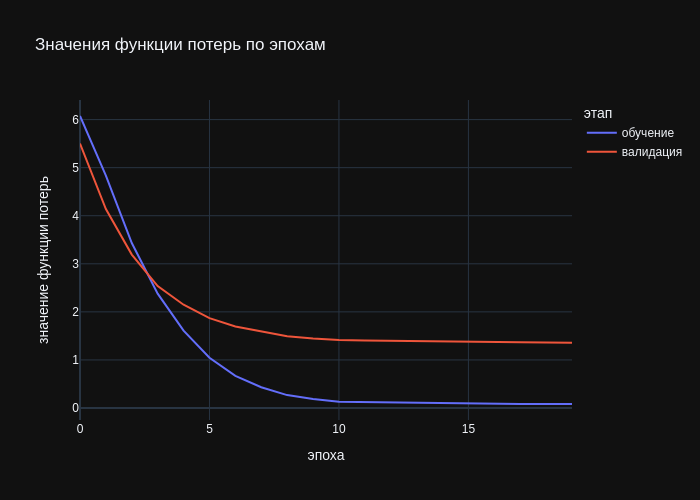

In [279]:
fig = px.line(losses, title='Значения функции потерь по эпохам', template='plotly_dark', 
             labels={'index': 'эпоха', 'value': 'значение функции потерь', 
                     'variable': 'этап'})
#fig.update_yaxes(range = [0, 1.4])
fig.show('png')

In [280]:
metrics = pd.DataFrame({'обучение': model.metrics['train'],
                       'валидация': model.metrics['valid'][1:]})

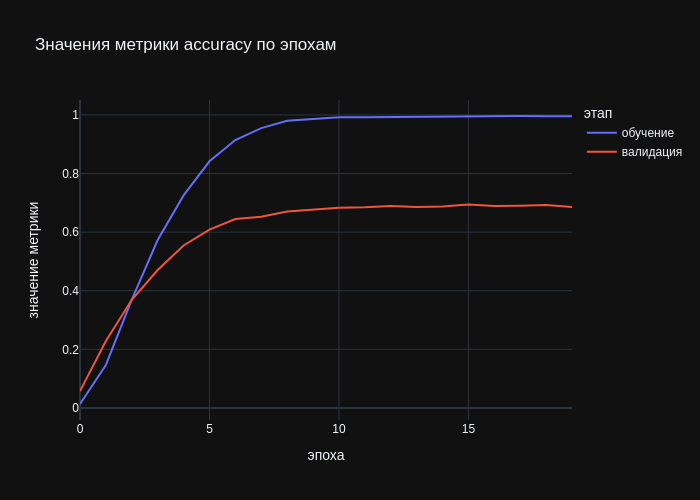

In [281]:
fig = px.line(metrics, title='Значения метрики accuracy по эпохам', template='plotly_dark', 
             labels={'index': 'эпоха', 'value': 'значение метрики', 
                     'variable': 'этап'})
#fig.update_yaxes(range = [0, 1.4])
fig.show('png')

In [282]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.388866901397705     │
│        test_metric        │    0.7020400762557983     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.388866901397705, 'test_metric': 0.7020400762557983}]

In [283]:
torch.save(model.state_dict(), 'class.pt')

In [12]:
model.load_state_dict(torch.load('class.pt'))

<All keys matched successfully>

Отлично. Нам удалось достичь достаточно высокого значения целевой метрики (`Accuracy > 70%`). Наша модель готова к дальнейшим экспериментам.

## Расчёт косинусной близости

Наша модель обучена, теперь мы можем использовать её для получения эмбедингов. Будем сравнивать эмбединги через косинусную близость. Возьмём несколько фотографий из обучающего и тестового наборов. Посчитаем косинусную близость между фотографиями одного и того же человека и разных людей.

Сначала нам нужно убрать «голову» у обученной модели, чтобы получать эмбединги.

In [13]:
module_list = list(list(model.children())[0].children())[:-1]
model_for_embedings = nn.Sequential(*module_list)

Теперь возьмём по батчу данных из обучающей и тестовой выборки. Для простоты увеличим размер батча.

In [14]:
data_module = CelebsDataModule(batch_size=256)

In [15]:
data_module.setup(stage=None)

In [16]:
X_batch_train, y_batch_train = next(iter(data_module.train_dataloader()))
X_batch_test, y_batch_test = next(iter(data_module.test_dataloader()))

Хорошо. Теперь нам нужно получить эмбединги и сгруппировать их по людям, которые изображены на фотографиях.

In [17]:
model_for_embedings.eval()
with torch.no_grad():
    model_for_embedings = model_for_embedings
    embedings = model_for_embedings(X_batch_train)

In [18]:
train_embedings = defaultdict(list)

for person, embedding in zip(y_batch_train, embedings):
    train_embedings[person.item()].append(embedding.to('cpu'))

In [19]:
with torch.no_grad():
    model_for_embedings = model_for_embedings
    embedings = model_for_embedings(X_batch_test)

In [20]:
test_embedings = defaultdict(list)

for person, embedding in zip(y_batch_test, embedings):
    test_embedings[person.item()].append(embedding.to('cpu'))

Найдём несколько ключей, которые попали в оба батча, и тех, которые есть только в батче из обучающей выборки.

In [21]:
list(set(train_embedings.keys()).intersection(set(test_embedings.keys())))[:5]

[1, 2, 3, 7, 8]

In [22]:
list(set(train_embedings.keys()).difference(set(test_embedings.keys())))[:5]

[81, 82, 86, 91, 94]

Хорошо. Например, ключ 8 есть в обоих батчах, а ключ 81 — только в обучающем батче. Сравним близость эмбедингов с восьмым ключём между собой, а потом с эмбедингом с 84 ключём.

In [23]:
F.cosine_similarity(train_embedings[8][0].flatten(), test_embedings[8][0].flatten(), dim=0)

tensor(0.4540)

In [24]:
F.cosine_similarity(train_embedings[81][0].flatten(), test_embedings[8][0].flatten(), dim=0)

tensor(0.2235)

Разница получилась не очень значительной, но всё же косинусная близость эмбедингов фотографий одного человека выше. Попробруем посмотреть на распределения косинусной близости.

Посчитаем косинусную близость между всеми фотографиями одного человека из обучающей выборки и его же фотографиями из тестовой выборки. Затем аналогично посчитаем косинусную близость для разных людей. Если мы всё сделали правильно, то распределения близостей будут отличаться.

In [25]:
train_embedings = defaultdict(list)
model_for_embedings.eval()
model_for_embedings = model_for_embedings.to('cuda')
with torch.no_grad():
    for X_batch, y_batch in tqdm(data_module.train_dataloader()):
        embedings = model_for_embedings(X_batch.to('cuda'))
        for person, embedding in zip(y_batch, embedings):
            train_embedings[person.item()].append(embedding.to('cpu'))

  0%|          | 0/34 [00:00<?, ?it/s]

In [26]:
test_embedings = defaultdict(list)
model_for_embedings.eval()
model_for_embedings = model_for_embedings.to('cuda')
with torch.no_grad():
    for X_batch, y_batch in tqdm(data_module.test_dataloader()):
        embedings = model_for_embedings(X_batch.to('cuda'))
        for person, embedding in zip(y_batch, embedings):
            test_embedings[person.item()].append(embedding.to('cpu'))

  0%|          | 0/7 [00:00<?, ?it/s]

Все эмбединги рассчитаны, посмотрим на распределения. Мы помним, что ключ 8 есть в обоих выборках, для него и произведём рассчёт.

In [27]:
co_sims = []
for train_embeding in train_embedings[8]:
    for test_embeding in test_embedings[8]:
        co_sims.append(F.cosine_similarity(train_embeding, 
                                           test_embeding, 
                                           dim=0).item())

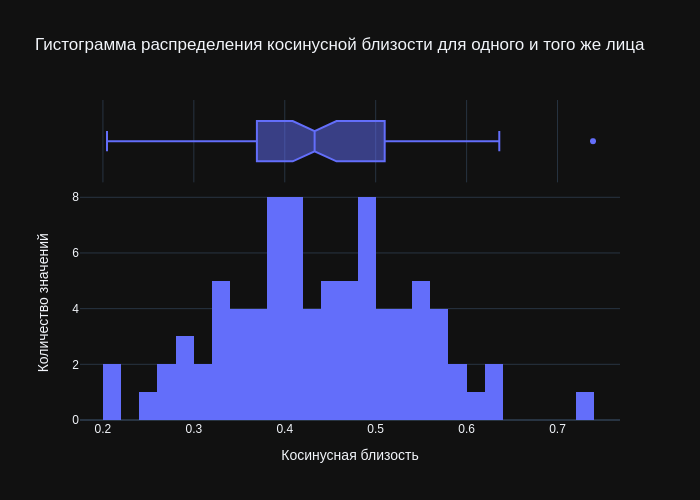

In [28]:
fig = px.histogram(co_sims, template='plotly_dark', nbins=40,
                   title='Гистограмма распределения косинусной близости для одного и того же лица',
                   marginal='box',labels={'value': 'Косинусная близость'})
fig.update_layout(yaxis_title='Количество значений')
fig.update(layout_showlegend=False)
fig.show('png')

In [29]:
co_sims = []
for test_embeding in test_embedings[81]:
    for key in train_embedings.keys():
        if key != 81:
            for train_embeding in train_embedings[key]:
                co_sims.append(F.cosine_similarity(train_embeding, 
                                                   test_embeding, 
                                                   dim=0).item())

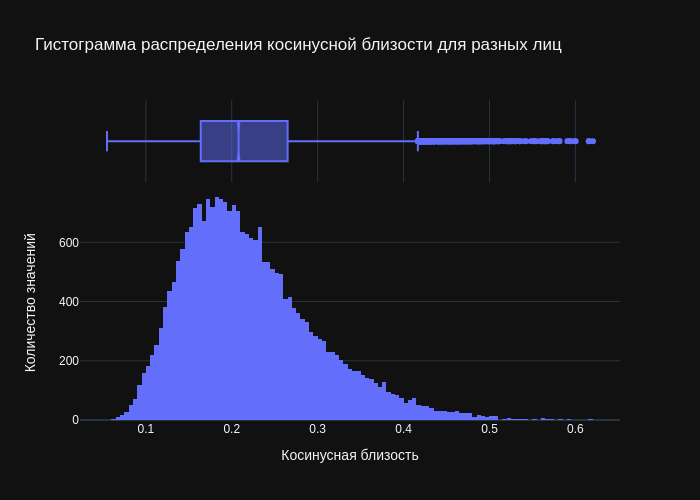

In [30]:
fig = px.histogram(co_sims, template='plotly_dark',
                   title='Гистограмма распределения косинусной близости для разных лиц',
                   marginal='box',labels={'value': 'Косинусная близость'})
fig.update_layout(yaxis_title='Количество значений')
fig.update(layout_showlegend=False)
fig.show('png')

Из построенных гистограмм видно, что распределение косинусной близости для эмбедингов фотографий лица одного и того же человека отличается от распределения косинусной близости эмбедингов фотографий разных людей, а значит мы всё сделали правильно и нашу модель можно использовать для распознавания лиц.

## Метрика `identificaton rate`

До этого при обучении модели мы использовали для оценки качества модели кросс-энтропию и `accuracy`. Но такой подход не позволяет нам оценить, как модель будет работать на лицах, которые раньше не видела (которые отсутствуют в обучающем, валидационном и тестовом наборах данных).

Для решения этой проблемы мы рассчитаем ещё одну метрику: `identificaton rate`. 

Пусть у нас есть два набора лиц: запросы `(query)` и помехи `(distractors)`. Лица из обоих наборов отсутствуют в обучающем, валидационном и тестовом наборах.
1. мы рассчитываем косинусную близость между всеми фотографиями, относящимися к одним и тем же людям в наборе `query`. Например, если человек изображён на трёх фотографиях из набора `query`, мы рассчитаем попарную близость между этими тремя фотографиями;
2. мы рассчитаем косинусную близость между всеми фотографиями, относящимися к разным людям в наборе `query`;
3. рассчитаем косинусную близость между всеми парами эмбедингов из наборов `query` и `distractors`;
4. просуммируем количество рассчитанных близостей, полученных на шагах два и три. Это — количество отрицательных пар;
5. зададим долю ложноположительных результатов `(FPR, false positive rate)`. Пусть в нашем случае `FPR=0.01`. Если умножить эту долю на количество отрицательных пар, полученное на шаге 4, мы получим количество ложно положительных результатов, которое может выдать модель. Обозначим это число как `N`;
6. отсортируем все близости отрицатльных пар по убыванию. Значение элемента `N` будем считать пороговой близостью;
7. рассчитаем количество положительных близостей, полученных на этапе 1, больше или равных пороговому значинию. Разделим это число на общее количество положительных близостей. Так мы получим долю истинно положительных результатов `(TPR, true positive rate)`, что и будет нашей метрикой.

Наборы данных `query` и `distractors` уже загружены в директорию `celebA_ir`. В файле `celebA_anno_query.csv` содержится разметка, к какому классу относятся фотографии из набора `query`.

Загрузим данные, получим имена файлов и классы.

In [53]:
with open('./celebA_ir/celebA_anno_query.csv', 'r') as f:
    query_lines = f.readlines()[1:]

query_lines = [x.strip().split(',') for x in query_lines]
query_img_names = [x[0] for x in query_lines]

In [54]:
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

Хорошо. Теперь у нас есть словарь, в котором имена файлов из набора `query` сгруппированы по классам. Теперь создадим список файлов из набора `distractors`.

In [55]:
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors') 

Отлично. Данные готовы, создадим вспомогательный класс для упрощения загрузки фотографий в нейросеть.

In [57]:
class MyDataset(Dataset):
    def __init__(self, images_list: list) -> None:
        super().__init__()
        self.images_list = images_list
        self.transform = transforms.Compose([
                transforms.Resize(160),
                transforms.CenterCrop(160),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                ])

    def __len__(self) -> int:
        return len(self.images_list)

    def __getitem__(self, idx: int) -> torch.tensor:
        img = self.images_list[idx]
        return self.transform(Image.open(img))

Нам пригодится функция для получения эмбедингов.

In [62]:
def compute_embeddings(model, images_list: list) -> list:
    '''
    расчёт эмбедингов файлов images_list
    params:
    model: обученная модель, получающая на вход изображения и возвращающая эмбединги
    images_list: список путей файлов для расчёта эмбедингов
    output:
    list: список эмбедингов
    '''
    data = DataLoader(MyDataset(images_list), 
                      batch_size=32, 
                      shuffle=False, 
                      num_workers=12)
    
    embedings = []
    model.eval()
    model = model.to('cuda')
    with torch.no_grad():
        for X_batch in tqdm(data):
            output = model(X_batch.to('cuda'))
            embedings += [emb for emb in output.to('cpu')]
    return embedings

Посчитаем эмбединги всех файлов из наборов `query` и `distractors`.

In [63]:
query_embeddings = compute_embeddings(model, [os.path.join('celebA_ir/celebA_query', img) for img in query_img_names])

  0%|          | 0/39 [00:00<?, ?it/s]

In [64]:
distractors_embeddings = compute_embeddings(model, [os.path.join('celebA_ir/celebA_distractors', img) for img in distractors_img_names])

  0%|          | 0/63 [00:00<?, ?it/s]

Отлично. Нам нужно ещё несколько вспомогательных функций. Напишем функцию для получения косинусных близостей между положительными парами.

In [69]:
def compute_cosine_query_pos(query_dict: dict, query_img_names: list, query_embeddings: list) -> list:
    '''
    расчёт косинусной близости между положительными парами
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: список названий файлов
    query_embeddings: список эмбедингов
    output:
    list of floats: косинусные близости между эмбедингами положительны пар
    '''
    
    similarities = []
    for _, images in tqdm(query_dict.items()):
        if len(images) > 1:
            pairs = combinations(images, 2)
            for pair in pairs:
                first_embeding = query_embeddings[query_img_names.index(pair[0])]
                second_embeding = query_embeddings[query_img_names.index(pair[1])]
                if not isinstance(first_embeding, torch.Tensor):
                    first_embeding = torch.Tensor(first_embeding)
                    second_embeding = torch.Tensor(second_embeding)
                similarities.append(F.cosine_similarity(first_embeding, 
                                                        second_embeding, 
                                                        dim=0))
            
    return similarities

А также функцию для расчёта косинусной близости между отрицательными парами.

In [72]:
def compute_cosine_query_neg(query_dict: dict, query_img_names: list, query_embeddings: list) -> list:
    '''
    расчёт косинусной близости между отрицательными парами
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: список названий файлов
    query_embeddings: список эмбедингов
    output:
    list of floats: косинусные близости между эмбедингами отрицательных пар в query
    '''
    similarities = []
    
    key_pairs = list(product(query_dict.keys(), query_dict.keys()))
    
    for key_pair in tqdm(key_pairs):
        if (key_pair[0] != key_pair[1]) and (key_pair[0] < key_pair[1]):
            images_pairs = product(query_dict[key_pair[0]],
                                   query_dict[key_pair[1]])
            for images_pair in images_pairs:
                first_embeding = query_embeddings[query_img_names.index(images_pair[0])]
                second_embeding = query_embeddings[query_img_names.index(images_pair[1])]
                if not isinstance(first_embeding, torch.Tensor):
                    first_embeding = torch.Tensor(first_embeding)
                    second_embeding = torch.Tensor(second_embeding)
                similarities.append(F.cosine_similarity(first_embeding, 
                                                        second_embeding, 
                                                        dim=0))

    return similarities

Хорошо. Осталось написать функцию расчёта косинусной близости между эмбедингами `query` и `distractors`.

In [73]:
def compute_cosine_query_distractors(query_embeddings: list, distractors_embeddings: list) -> list:
    '''
    расчёт косинусной близости между парами query и distractors
    params:
    query_embeddings: список эмбедингов query
    distractors_embeddings: список эмбедингов distractors
    output:
    list of floats: список попарных эмбедингов
    '''
    similarities = []
    pairs = list(product(query_embeddings, distractors_embeddings))
    for pair in tqdm(pairs):
        if not isinstance(pair[0], torch.Tensor):
                    pair = (torch.Tensor(pair[0]),
                            torch.Tensor(pair[1]))
        similarities.append(F.cosine_similarity(pair[0], 
                                                pair[1], 
                                                dim=0))
    return similarities

In [70]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)

  0%|          | 0/51 [00:00<?, ?it/s]

In [74]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)

  0%|          | 0/2601 [00:00<?, ?it/s]

In [75]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

  0%|          | 0/2445222 [00:00<?, ?it/s]

Отлично. Мы готовы к тому, чтобы написать функцию для расчёта `identification rate`.

In [78]:
def compute_ir(cosine_query_pos: list, 
               cosine_query_neg: list, 
               cosine_query_distractors: list, 
               fpr: float = 0.1) -> tuple:
    '''
    расчёт identification rate для заданного fpr
    params:
    cosine_query_pos: косинусные близости между положительными парами в query
    cosine_query_neg: косинусные близости между отрицательными парами в query
    cosine_query_distractors: попарные косинусные близости между query и distractors
    fpr: false positive rate
    output: 
    float: пороговое значение для заданного fpr 
    float: TPR при заданном fpr
    '''
    f_pairs, _ = torch.sort(torch.tensor(cosine_query_neg + cosine_query_distractors), descending=True)
    f_pos_thr = int(f_pairs.shape[0] * fpr)
    thr_similarity = f_pairs[f_pos_thr]
    cosine_query_pos = torch.tensor(cosine_query_pos)
    tpr = (cosine_query_pos >= thr_similarity).sum() / cosine_query_pos.shape[0]
    return thr_similarity.item(), tpr

Ура! Мы готовы рассчитать TPR для нескольких FPR!

In [93]:
thr = []
tpr = []
for fpr in tqdm(np.arange(0.01, 0.5, 0.01)):
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y.item())

  0%|          | 0/49 [00:00<?, ?it/s]

Построим график зависимости `TPR` (доли истинно положительных ответов) от `FPR` (доли ложно положительных ответов). Выгнутость этого графика позволит нам судить о качестве нашей модели.

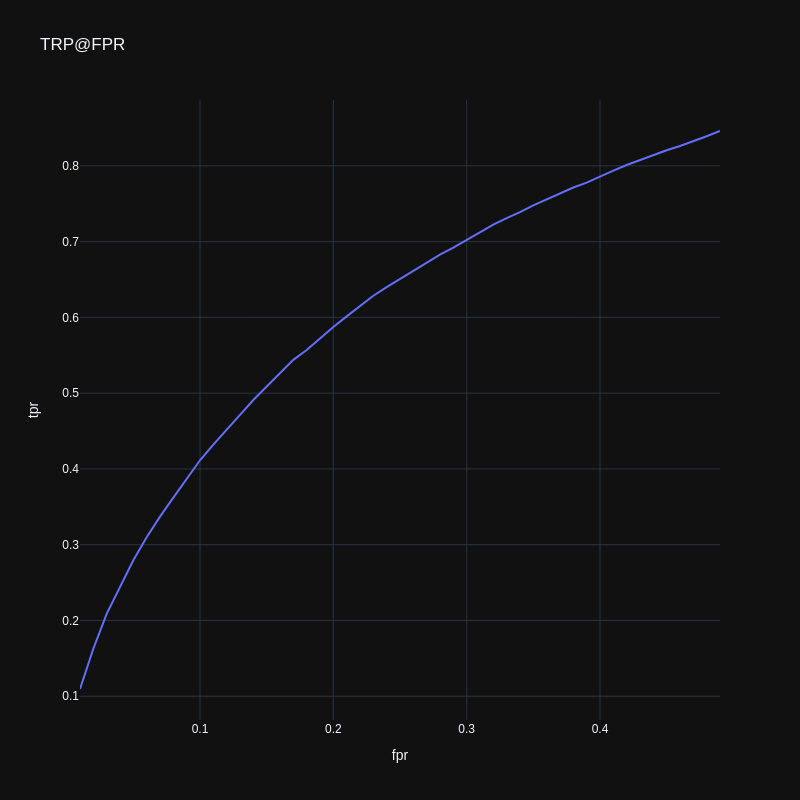

In [95]:
fig = px.line(pd.DataFrame({'tpr': tpr, 'fpr': np.arange(0.01, 0.5, 0.01)}),
              title='TRP@FPR', template='plotly_dark', x='fpr', y='tpr', width=800, height=800)
fig.show('png')

Красота! Данный график позволяет нам оценить, насколько хорошо наша модель будет справляться с классификацией ранее неизвестных лиц.

## Дополнительные функции потерь

До этого при обучении нейросети в качестве функции потерь мы использовали кросс-энтропию. Однако для решения задачи распознавания лиц существуют и другие функции потерь. Попробуем применить их и посмотрим, как это скажется на целевой метрике. Обзор функций потерь, применяемых при распознавании лиц, приведён в статье [A Performance Evaluation of Loss Functions for Deep Face Recognition](https://arxiv.org/pdf/1901.05903.pdf).

### `Triplet Loss`

Данная функция потерь не требует наличия у модели финального классифицируюшего слоя — она работает непосредственно с эмбедингами. `Triplet loss` спроектирована таким образом, чтобы эмбединги одного человека были близки друг к другу, а эмбединги разных людей были взаимно удалены. У этой функции потерь есть ещё одно преимущество перед кросс-энтропией: нам не требуется указывать количество классов в датасете. Если в данных появляются новые люди, нам не приходится переобучать всю сеть, достаточно лишь дообучить её на новых фотографиях.

Разберёмся, как работает Triplet Loss.

Во-первых, нам не нужен классифицирующий слой. На выходе из нейросети мы получаем эмбединг фотографии.

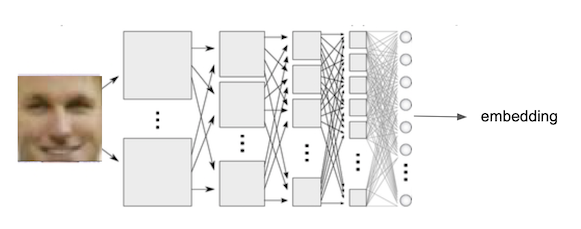

Идея заключается в том, чтобы эмбединги одних и тех же людей были ближе друг к другу, а эмбединги разных людей располагались подальше.

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

где 
- $e$ — эмбединг фотографии (результат работы модели)
- $p$ — позитивный эмбединг (мы хотим, чтобы $e$ был ближе к нему)
- $n$ — негативный эмбединг (мы хотим, чтобы $e$ был дальше от него)
- $d(x, y)$ — расстояние между эмбедингами 
- margin — гипер-параметр, положительное число, чтобы увеличить разницу между $d(a, p)$ и $d(a, n)$

В нашем случае для фотографии $E$ и её эмбединга $e$ позитивным эмбедингом $p$ будет эмбединг фотографии того же человека, негативным эмбедингом $n$ — любого другого человека.

Наша реализация `Triplet Loss` основана на реализации, взятой из [этого репозитория](https://github.com/lyakaap/NetVLAD-pytorch).

In [9]:
data_module = CelebsDataModule(batch_size=128)

In [24]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.6)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (i_equal_k ^ 1)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [25]:
class ResNextTriplet(L.LightningModule):
    def __init__(self, learning_rate: float = 0.001) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.classes = 500
        resnext = torch.hub.load('pytorch/vision:v0.10.0', 
                                    'resnext50_32x4d', 
                                    weights='DEFAULT')
        module_list = list(resnext.children())[:-1]
        self.model = nn.Sequential(*module_list)
        
        self.loss = lsss.ArcFaceLoss(num_classes=500, 
                                       embedding_size=2048)

        self.losses = {
            'train': [],
            'valid': [],
            'test': []
        }
        
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, input):
        return self.model(input)

    def _shared_step(self, input, stage):
        X, y = input
        embedings = self.forward(X)

        results = {
            'loss': self.loss(embedings[:, :, 0, 0], y)
        }

        getattr(self, f'{stage}_step_outputs').append(results)
        
        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')

        loss = torch.tensor([x['loss'] for x in outputs]).mean().item()

        getattr(self, f'{stage}_step_outputs').clear()
        
        self.losses[stage].append(loss)
        
        results = {f'{stage}_loss': loss}
        
        self.log_dict(results, prog_bar=True)
    
    def training_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'valid')
    
    def test_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self) -> None:
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self) -> None:
        self._shared_epoch_end('valid')

    def on_test_epoch_end(self) -> None:
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': StepLR(
                optimizer,
                step_size=10,
                gamma=0.5), 
                'interval': 'epoch',
                'monitor': 'valid_loss'}
        
        return [optimizer], [scheduler]

In [26]:
model = ResNextTriplet()

Using cache found in /home/dev/.cache/torch/hub/pytorch_vision_v0.10.0


In [33]:
trainer = L.Trainer(max_epochs=20, logger=False, precision=16)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model, data_module)

/home/dev/DLS/diploma_ru/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning:

Checkpoint directory /home/dev/DLS/diploma_ru/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | Sequential  | 23.0 M
1 | loss  | ArcFaceLoss | 1.0 M 
--------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.016    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [35]:
losses = pd.DataFrame({'обучение': model.losses['train'],
                       'валидация': model.losses['valid'][1:]})

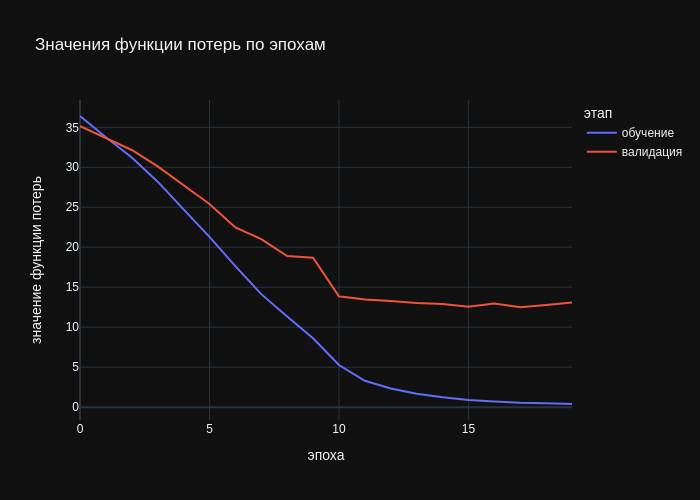

In [36]:
fig = px.line(losses, title='Значения функции потерь по эпохам', template='plotly_dark', 
             labels={'index': 'эпоха', 'value': 'значение функции потерь', 
                     'variable': 'этап'})
#fig.update_yaxes(range = [0, 1.4])
fig.show('png')

In [37]:
torch.save(model.state_dict(), 'tr-loss-class.pt')

In [27]:
model.load_state_dict(torch.load('tr-loss-class.pt'))

<All keys matched successfully>

In [28]:
def class_mean_embeddings(embeddings: torch.tensor, 
                          labels: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
    '''
    get mean embedding for each label
    params:
    embeddings: embeddings of images
    labels: corresponding labels
    output:
    tuple: mean embeddings and corresdonding labels
    '''
    mean_embeddings = []
    classes = []
    
    for label in labels.unique():
        class_embeddings = embeddings[labels == label]
        mean_embeddings.append(class_embeddings.mean(0))
        classes.append(label)

    mean_embeddings = torch.stack(mean_embeddings)
    classes = torch.tensor(classes)
        
    return mean_embeddings, classes

In [29]:
def get_embeddings(model, dataloader: DataLoader) -> tuple[torch.tensor, torch.tensor]:
    '''
    get embeddings and corresponding labels for every image from dataloader
    params:
    model: pertrained model
    dataloader: dataloader of images and labels
    output:
    tuple: embeddings and corresdonding labels
    '''
    model = model.to('cuda')
    model.eval()
    
    embeddings = []
    labels = []

    for X_batch, y_batch in tqdm(dataloader):
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')

        with torch.no_grad():
            emb = model(X_batch)
            embeddings.append(emb)
            labels.append(y_batch)

    return torch.cat(embeddings, dim=0), torch.cat(labels)

In [30]:
def predict(embeddings: torch.tensor, references: torch.tensor, classes: torch.tensor) -> torch.tensor:
    similarities = []
    for embedding in embeddings:
        similarities_emb = []
        for reference in references:
            similarities_emb.append(F.cosine_similarity(embedding, reference, dim=0).item())
        similarities.append(similarities_emb)
    similarities = torch.tensor(similarities)
    nearest_index = torch.argmax(similarities, dim=1)
    predicted_class = classes[nearest_index]

    return predicted_class

In [31]:
tr_embeddings, tr_labels = get_embeddings(model, data_module.train_dataloader())

  0%|          | 0/134 [00:00<?, ?it/s]

Визуализируем полученные эмбединги, чтобы оценить качество обучения.

In [32]:
emb_tsne = TSNE(n_components=2).fit_transform(torch.squeeze(tr_embeddings.cpu()))

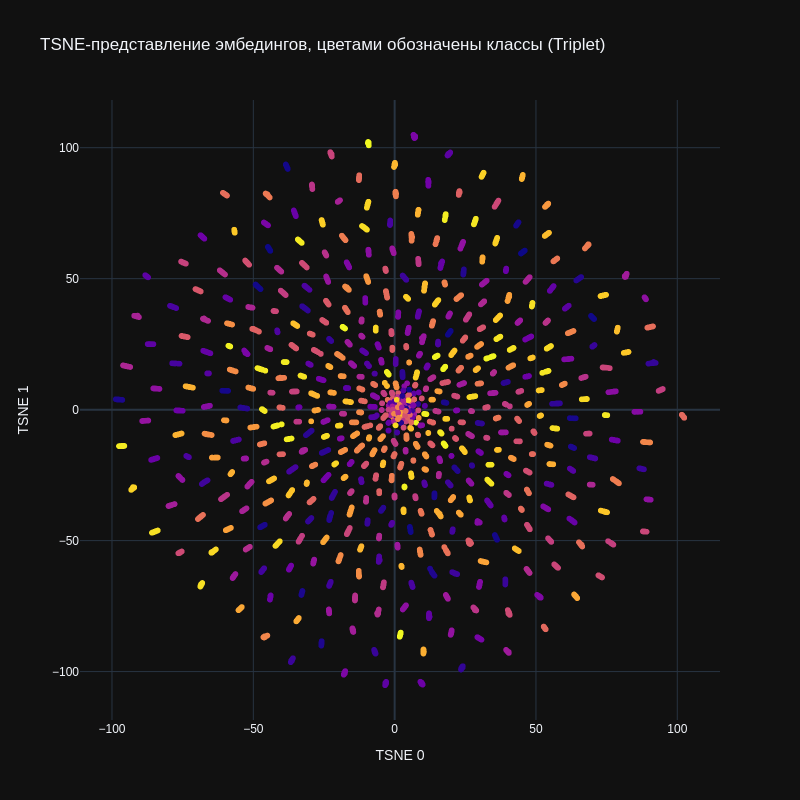

In [33]:
fig = px.scatter(x=emb_tsne[:, 0], y=emb_tsne[:, 1], color=tr_labels.cpu(),
                 title='TSNE-представление эмбедингов, цветами обозначены классы (Triplet)',
                 height=800, width=800,
                 template='plotly_dark', labels={'x': 'TSNE 0',
                                                'y': 'TSNE 1'})

fig.update_coloraxes(showscale=False)
fig.show('png')

Великолепный график, видно, что эмбединги различных классов легко отделимы друг от друга.

In [48]:
reference_emb, reference_class = class_mean_embeddings(tr_embeddings, tr_labels)

In [49]:
model = model.to('cuda')
model.eval()
y_pred = []
y_true = []
for X_batch, y_batch in tqdm(data_module.val_dataloader()):
    with torch.no_grad():
        embedings = model(X_batch.to('cuda'))
    predicted_class = predict(embedings, reference_emb, reference_class)
    y_pred.append(predicted_class)
    y_true.append(y_batch)

  0%|          | 0/15 [00:00<?, ?it/s]

In [50]:
y_pred = torch.cat(y_pred)

In [51]:
y_true = torch.cat(y_true)

In [52]:
Accuracy(task='multiclass', num_classes=500, average='micro')(y_true, y_pred)

tensor(0.7859)

Использование функции потерь `Triplet` повзолило заметно увеличить целевую метрику `Accuracy` с примерно 70 до примерно 79 процентов. Хороший результат.

### `ArcFace Loss`

[Оригинальная статья](https://arxiv.org/pdf/1801.07698.pdf), [репозиторий авторов](https://github.com/deepinsight/insightface)

Данная функция потерь может считаться `SOTA` для систем распознавания лиц (при этом стоит учитывать, что для различных архитектур нейросетей наилучшие результаты могут достигаться и с другими функциями потерь). `ArcFace loss` во многом схожа с кросс-энтропией, но при этом позволяет получать лучшее распределение эмбедингов на сфере. Для достижения большей компактности эмбедингов одного класса и увеличения расстояния между эмбедингами разных классов вводятся дополнительные геодезические ограничения.

Разберёмся в том, как работает `ArcFace`.
По сути, мы имеем дело с модификацией стандартной кросс-энтропии, направленной на то, чтобы эмбединги различных классов находились дальше друг от друга, таким образом их различие становится более явным.

Вспомним формулу софтмакса кросс-энтропии для задачи классификации:
$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

где:
- $x_i \in \mathbb{R^d}$ — глубокое представление $i$-го элемента, принадлежащего к классу $y_i$;
- $W_j \in \mathbb{R^d}$ — j-ая колонка весов;
- $W \in \mathbb{R^d}$ — матрица весов;
- $b_j \in \mathbb{R^d}$ — смещение;
- $N$ — размер батча;
- $n$ — номер класса.

Данная функция потерь позволяет решать задачу многоклассовой классификации, но в ней нет условий для увеличения расстояния между эмбедингами разных классов и уменьшения расстояния между эмбедингами одного класса, что важно при распознавании лиц.

Давайте немного изменим нашу формулу:
- установим смещение $b_j=0$;
- нормализуем веса ||$W_j$|| = 1;
- нормализуем эмбединг ||$x_i$|| = 1 и отмасштабируем его до $s$ ($s$ — гиперпараметр).

Нормализация эмбедингов и весов приводит к тому, что предсказания зависят только от угла между эмбедингом и весом. Таким образом, выучиваемые эмбединги распределяются по гиперсфере радиуса $s$.

Теперь наша функция потерь выглядит так:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Наконец, добавим штраф $m$ за угол между $x_i$ и $W_{y_i}$, чтобы одновременно улучшать внутриклассовую компактность и межклассовую разницу:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Полученная функия потерь будет иметь два гиперпараметра: $m$ и $s$.

Чтож, теперь мы готовы обучить нашу нейросеть с новой функцией потерь.

In [9]:
data_module = CelebsDataModule(batch_size=64)

In [11]:
class ResNextArc(L.LightningModule):
    def __init__(self, learning_rate: float = 0.001) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.classes = 500
        resnext = torch.hub.load('pytorch/vision:v0.10.0', 
                                    'resnext50_32x4d', 
                                    weights='DEFAULT')
        module_list = list(resnext.children())[:-1]
        self.model = nn.Sequential(*module_list)
        
        self.loss = lsss.ArcFaceLoss(num_classes=500, 
                                       embedding_size=2048)

        self.losses = {
            'train': [],
            'valid': [],
            'test': []
        }
        
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, input):
        return self.model(input)

    def _shared_step(self, input, stage):
        X, y = input
        embedings = self.forward(X)

        results = {
            'loss': self.loss(embedings[:, :, 0, 0], y)
        }

        getattr(self, f'{stage}_step_outputs').append(results)
        
        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')

        loss = torch.tensor([x['loss'] for x in outputs]).mean().item()

        getattr(self, f'{stage}_step_outputs').clear()
        
        self.losses[stage].append(loss)
        
        results = {f'{stage}_loss': loss}
        
        self.log_dict(results, prog_bar=True)
    
    def training_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'valid')
    
    def test_step(self, batch, batch_idx) -> dict:
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self) -> None:
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self) -> None:
        self._shared_epoch_end('valid')

    def on_test_epoch_end(self) -> None:
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': StepLR(
                optimizer,
                step_size=10,
                gamma=0.5), 
                'interval': 'epoch',
                'monitor': 'valid_loss'}
        
        return [optimizer], [scheduler]

In [12]:
model = ResNextArc()

Using cache found in /home/dev/.cache/torch/hub/pytorch_vision_v0.10.0


In [57]:
trainer = L.Trainer(max_epochs=20, logger=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(model, data_module)

/home/dev/DLS/diploma_ru/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning:

Checkpoint directory /home/dev/DLS/diploma_ru/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | Sequential  | 23.0 M
1 | loss  | ArcFaceLoss | 1.0 M 
--------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.016    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [59]:
losses = pd.DataFrame({'обучение': model.losses['train'],
                       'валидация': model.losses['valid'][1:]})

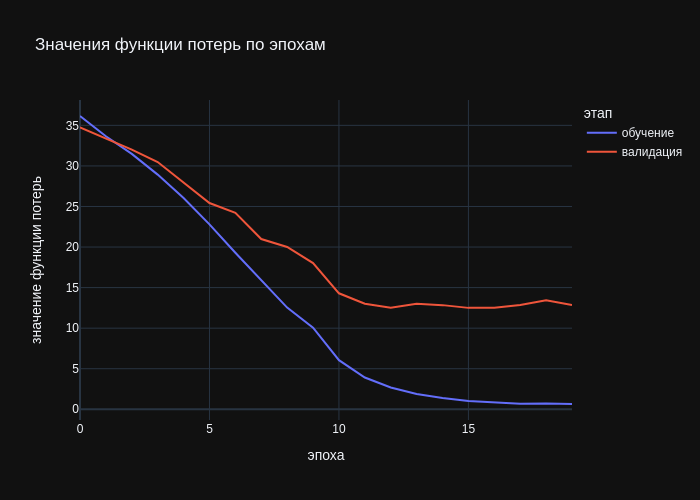

In [60]:
fig = px.line(losses, title='Значения функции потерь по эпохам', template='plotly_dark', 
             labels={'index': 'эпоха', 'value': 'значение функции потерь', 
                     'variable': 'этап'})
#fig.update_yaxes(range = [0, 1.4])
fig.show('png')

In [61]:
torch.save(model.state_dict(), 'arc-loss-class.pt')

In [13]:
model.load_state_dict(torch.load('arc-loss-class.pt'))

<All keys matched successfully>

In [14]:
def class_mean_embeddings(embeddings: torch.tensor, 
                          labels: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
    '''
    get mean embedding for each label
    params:
    embeddings: embeddings of images
    labels: corresponding labels
    output:
    tuple: mean embeddings and corresdonding labels
    '''
    mean_embeddings = []
    classes = []
    
    for label in labels.unique():
        class_embeddings = embeddings[labels == label]
        mean_embeddings.append(class_embeddings.mean(0))
        classes.append(label)

    mean_embeddings = torch.stack(mean_embeddings)
    classes = torch.tensor(classes)
        
    return mean_embeddings, classes

In [15]:
def get_embeddings(model, dataloader: DataLoader) -> tuple[torch.tensor, torch.tensor]:
    '''
    get embeddings and corresponding labels for every image from dataloader
    params:
    model: pertrained model
    dataloader: dataloader of images and labels
    output:
    tuple: embeddings and corresdonding labels
    '''
    model = model.to('cuda')
    model.eval()
    
    embeddings = []
    labels = []

    for X_batch, y_batch in tqdm(dataloader):
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')

        with torch.no_grad():
            emb = model(X_batch)
            embeddings.append(emb)
            labels.append(y_batch)

    return torch.cat(embeddings, dim=0), torch.cat(labels)

In [16]:
def predict(embeddings: torch.tensor, references: torch.tensor, classes: torch.tensor) -> torch.tensor:
    similarities = []
    for embedding in embeddings:
        similarities_emb = []
        for reference in references:
            similarities_emb.append(F.cosine_similarity(embedding, reference, dim=0).item())
        similarities.append(similarities_emb)
    similarities = torch.tensor(similarities)
    nearest_index = torch.argmax(similarities, dim=1)
    predicted_class = classes[nearest_index]

    return predicted_class

In [19]:
tr_embeddings, tr_labels = get_embeddings(model, data_module.train_dataloader())

  0%|          | 0/134 [00:00<?, ?it/s]

Визуализируем полученные эмбединги, чтобы оценить качество обучения.

In [21]:
emb_tsne = TSNE(n_components=2).fit_transform(torch.squeeze(tr_embeddings.cpu()))

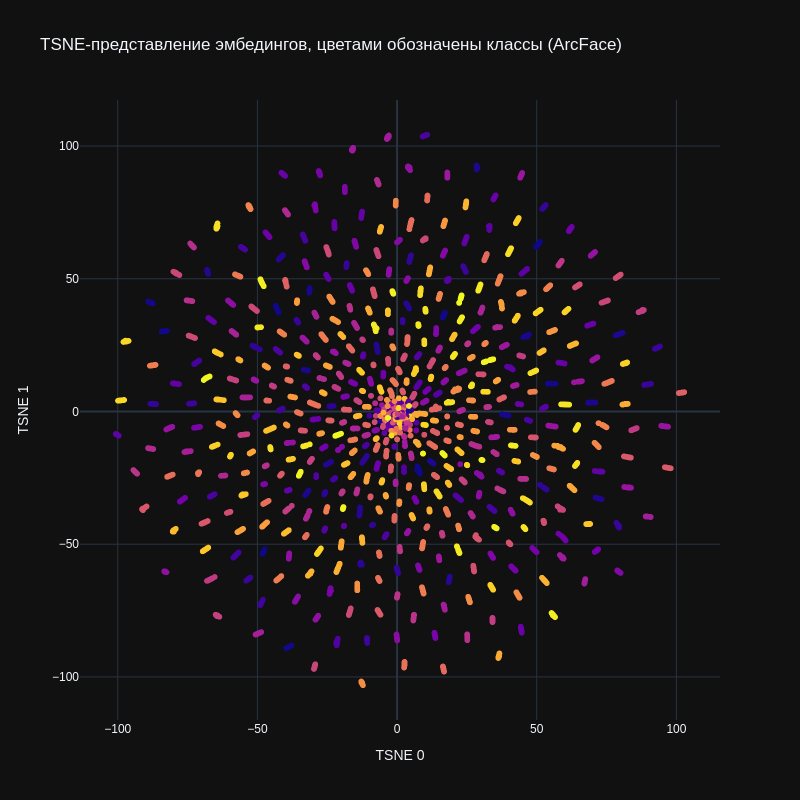

In [22]:
fig = px.scatter(x=emb_tsne[:, 0], y=emb_tsne[:, 1], color=tr_labels.cpu(),
                 title='TSNE-представление эмбедингов, цветами обозначены классы (ArcFace)',
                 height=800, width=800,
                 template='plotly_dark', labels={'x': 'TSNE 0',
                                                'y': 'TSNE 1'})

fig.update_coloraxes(showscale=False)
fig.show('png')

Великолепный график, видно, что эмбединги различных классов легко отделимы друг от друга.

In [22]:
reference_emb, reference_class = class_mean_embeddings(tr_embeddings, tr_labels)

In [23]:
model = model.to('cuda')
model.eval()
y_pred = []
y_true = []
for X_batch, y_batch in tqdm(data_module.val_dataloader()):
    with torch.no_grad():
        embedings = model(X_batch.to('cuda'))
    predicted_class = predict(embedings, reference_emb, reference_class)
    y_pred.append(predicted_class)
    y_true.append(y_batch)

  0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
y_pred = torch.cat(y_pred)

In [25]:
y_true = torch.cat(y_true)

In [26]:
Accuracy(task='multiclass', num_classes=500, average='micro')(y_true, y_pred)

tensor(0.8030)

Отлично! Мы обучили нашу модель с функцией потерь `ArcFace` и получили ещё более высокое значение целевой метрики (более 80%)!

## Вывод

В этом проекте мы решали задачу распознавания лиц. В общем случае задача поиска и распознавания лиц решается в несколько этапов:

1. обнаружение лица
2. выравнивание лица
3. распознавание лица

Обычно за каждый из этапов отвечает отдельная нейронная сеть. В нашей работе мы сконцентрировались на решении только задачи распознавания.

Мы описали процесс подготовки данных (фотографий лиц) для распознавания, который также разбивается на этапы:
1. для каждой фотографии определяются координаты элементов лица (глаз, носа, уголков рта)
2. каждая фотография вращается таким образом, чтобы координаты глаз располагались на заренее заданной горизонтальной линии;
3. каждая фотография масштабируется, чтобы размеры всех лиц были примерно схожими.

В нашей работе мы использовали уже подготовленные данные, все фотографии были правильным образом развёрнуты и отмасштабированы. Всего в наших данных были фотографии 500 человек.

Для базовой модели мы взяли нейросеть архитектуры `ResNext` и заменили ей классифицирующий слой. В качестве функции потерь мы использовали кросс-энтропию. После обучения на тестовой выборке нам удалось достичь значения целевой метрики `Accuracy > 70%`.

Уже обученную базовую модель мы использовали для получения эмбедингов и анализа их косинусной близости. Идея заключалась в том, что если наша модель обучена правильно, косинусная близость эмбедингов различных фотографий одного и того же человека будет больше, чем эмбедингов фотографий разных людей. Для проверки нашей модели мы определили классы, которые есть как в обучающей, так и в тестовой выборке, а также классы, которые есть только в тестовой выборке. Затем мы построили две гистограммы: на одной мы отобразили косинусные близости всех эмбедингов фотографий одного и того же человека в обучающей и тестовой выборке. На второй гистограмме мы отобразили косинусные близости эмбедингов фотографий разных людей. 

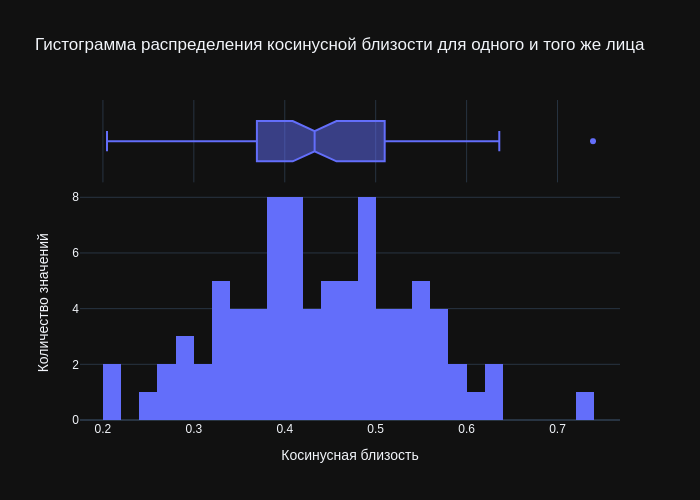

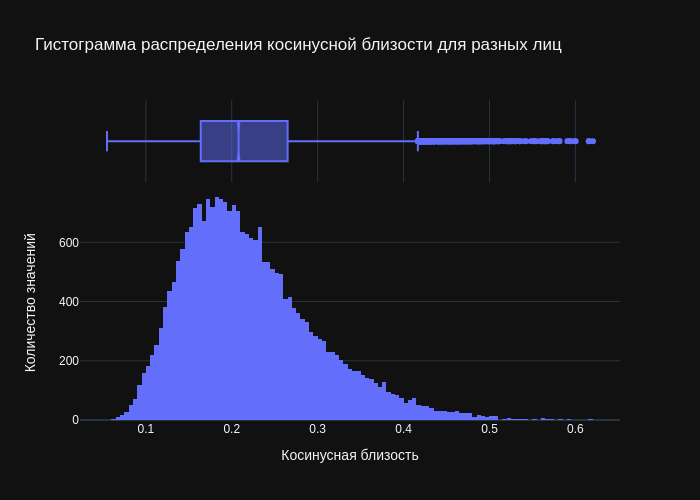

Из полученных графиков видно, что оба распределения заметно отличаются друг от друга, а значит наша базовая модель была обучена правильно.

Мы также описали и применили метрику `identification rate`. В отличие от метрики `Accuracy`, по которой мы оценивали базовую модель, `identification rate` позволяет понять, несколько хорошо наша модель будет справляться с классификацией ранее неизвестных лиц. Для наглядной оценики значения метрики мы построили график зависимости `TPR` (доля истинно положительных ответов модели) от `FPR` (доля ложно положительных ответов модели).

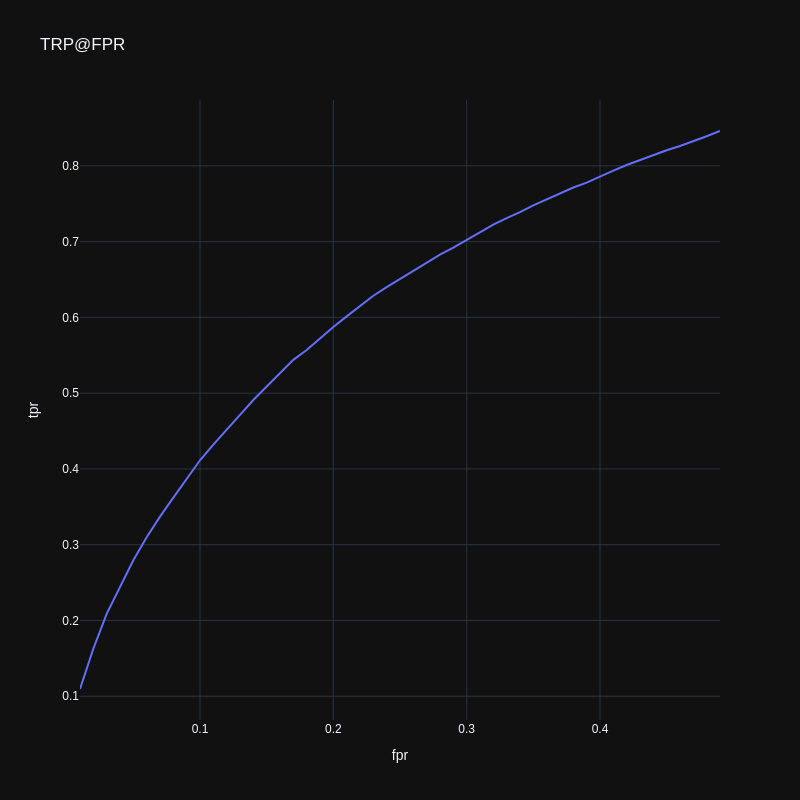

Форма графика (выпуклость кривой) говорит о том, что наша модель обучилась и позволяет получать осмысленные предсказания.

В рамках данной работы мы также провели эксперименты с функциями потерь `Triplet Loss` и `ArcFace Loss`. Эти функции потерь получают на вход эмбединги изображений и штрафуют нейросеть таким образом, чтобы эмбединги изображений одного класса (фотографий одного и того же человека) были ближе друг к другу, а эмбединги изображений разных классов (фотографий разных людей) были дальше друг от друга. Этот подход имеет важное преимущество: при появлении новых классов (фотографий новых людей) модель не приходится обучать заново, достаточно дообучить модель на новых данных.

Для наглядности мы визуализировали `TSNE`-разложение эмбедингов после обучения модели с функциями потерь `Triplet Loss` и `ArcFace Loss`.

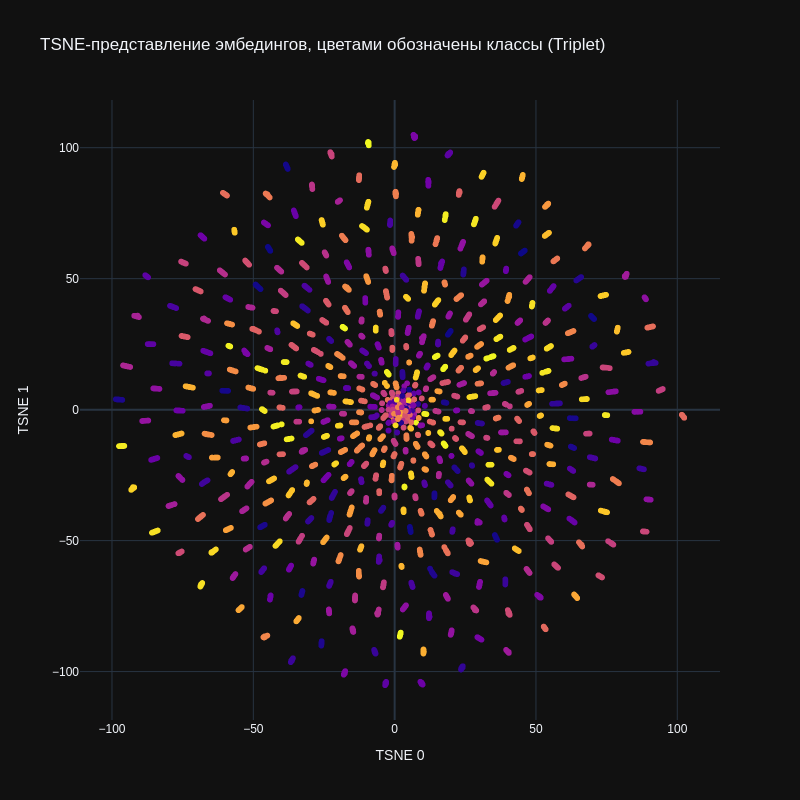

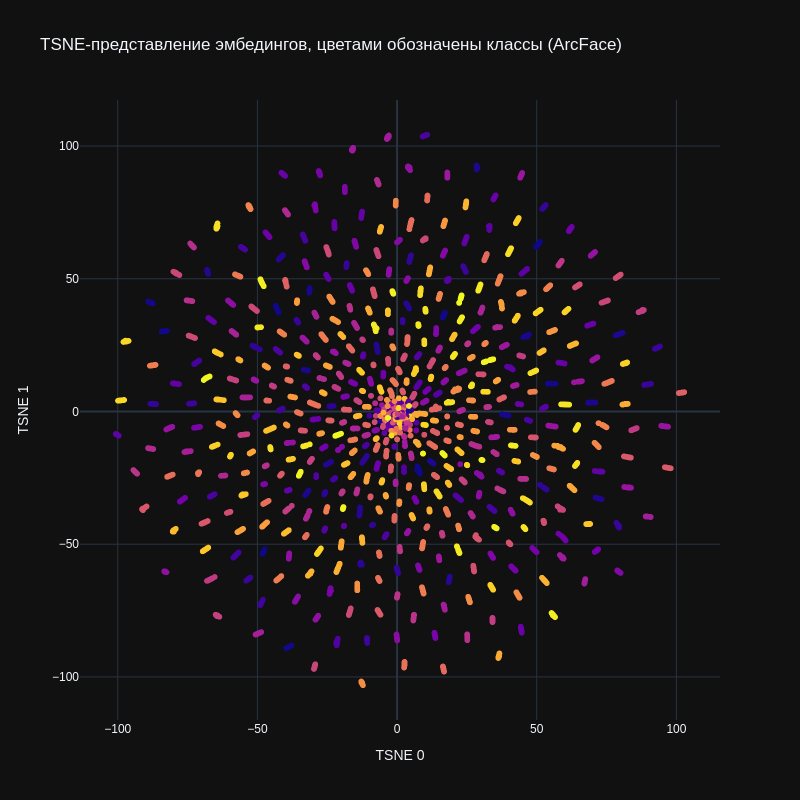

На обоих графиках видно, что эмбединги изображений действительно группируются по классам, при этом группы различных классов легко визуально отделимы друг от друга. 

Благодаря обучению моделей с функциями потерь `Triplet` и `ArcFace` удалось добиться значений целевой метрики `Accuracy` 79 и 80 процентов соответственно. Значения метрик для всех трёх моделей приведены в таблице ниже.

| Модель (функция потерь) | Значение `Accuracy` |
| ----------------------- | ------------------- |
| ResNext (cross-entropy) | 70 %                |
| ResNext (Triplet)       | 79 %                |
| ResNext (ArcFace)       | 80 %                |

Таким образом в данной работе мы показали, какие методы применяются при решении задачи распознавания лиц, какие метрики можно применять для оценки эффективности распознавания, какие функции потерь могут быть использованы для заметного повышения качества работы базовой модеи. 

Полученные модели могут применяться для решения различных задач: непосредственно для распознавания лиц, для поиска неизвестных (незарегистрированных) лиц в общем наборе фотографий, для поиска фотографий похожих лиц.